# Regression

In this example, we use the public dataset [California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) that was first described in the paper: Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.

The data are about prices for houses in California, USA and the target variable is the natural logarithm of the median house price.

We will use this example to explore how we an utilise hierarchical features and building a model pipeline in Scikit-Learn.

The data can be obtained from the web-page above or, as this is a popular training dataset, using the convenience function [fetch_california_housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) provided by scikit-learn. We will use a local copy in this exercise that has been obtained using this function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn import metrics
from sklearn import base
from sklearn import neighbors
from sklearn import pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

import profile_plot

# Data

First, we obtain the data using the inbuilt function.
Note that the first column is just the dataset index for a specific record - we need to drop this when we want to build our features later.

In [2]:
##
## use convenience function to access data and save a local copy.
##
#df = fetch_california_housing(return_X_y=False, as_frame=True).frame
#df.to_csv('california_housing.csv')

##
## here we load the local copy to avoid internet traffic 
##
df = pd.read_csv('data/housing/california_housing.csv')
df.head(5)

,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [35]:
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [36]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


# Exploratory Data Analysis

Before we start with the modelling, we want to get a feel for the data and look at some variables.
We start with some univariate plots.

First, the target (MedHouseVal). This is the natural log of the median house value in a given area.

***Discuss***

What do you notice about the target variable and what will this likely mean for the development of a model?

In [3]:
##
## your code here
##


***Discuss***\
What does this mean for the model development?



We now look at a few other plots.

In [4]:
##
## your code here
##

In [5]:
##
## also do some 2D scatter plots or similar
##

### Map data
The dataset also contains the latitude and longitude of the properties.
First, we make a scatter-plot to explore this data:

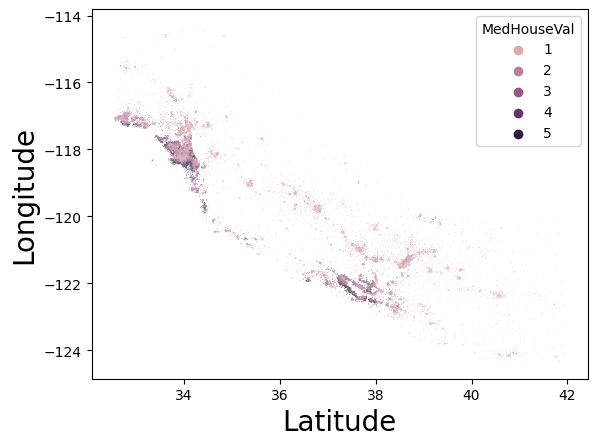

In [66]:
sns.scatterplot(data=df, x='Latitude', y='Longitude', hue='MedHouseVal', s=0.3 )
plt.xlabel('Latitude', size = 20)
plt.ylabel('Longitude', size = 20)
plt.show()

As we can see, the houses are located in areas we visually recognise as Californa, with areas such as Los Angeles or San Francisco densely populted and the deseart areas almost empty. The more expensive houses are also located in the popular cities, just as we would expect.

However, we need to think about how we can make use of this information.


# Machine Learning Model

We start with a base model that contains the numerical features we can use straight away (i.e. without latitude and longitude)

We follow the typical Scikit-Learn approach of:
- create an instance of the model
- call the ```fit``` method for the training data
- call the ```predict``` method for the test data.

As an example, we will use the [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

However, first we need to define the training/test data, the features and the labels.
The target (label) is the last column in the data-frame.



In [82]:
train_cols = ['MedInc', 'HouseAge','AveRooms','AveBedrms','Population','AveOccup']
label = df.columns[-1]
X = df[train_cols]
y = df[label]

# split into training and test sample
###
### Your code here
###
X_train, X_test, y_train, y_test = # ....

In [7]:
###
### Your code here
###
#model =  ...


Then, we obtain the predictions on the test data for the model.
For convenience, we make a copy of the test data and append the predictions, together with the true values,  as the last column to the dataframe

In [84]:
predictions = X_test.copy()
y_hat = model.predict(predictions)
predictions.loc[:,'y_hat'] = y_hat
predictions.loc[:,'y'] = y_test
predictions.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,y_hat,y
12277,2.8783,5.0,5.821086,1.172524,798.0,2.549521,1.206398,1.052
14831,2.8089,30.0,4.400000,1.079339,1997.0,3.300826,1.599351,1.206
14099,2.2287,29.0,3.707865,1.114607,882.0,1.982022,1.911623,1.400
11269,3.6531,18.0,5.642638,1.064417,1820.0,2.791411,1.572099,1.435
16478,3.3929,28.0,5.673961,1.065646,1365.0,2.986871,1.359892,1.130


Now we plot the distribution of predictions and true values, together with some global metrics.

In [8]:
print('MAD: {0:0.2f}, MSE {1:0.2f}'.format(metrics.mean_absolute_error(y_test, y_hat), 
                                           metrics.mean_squared_error(y_test, y_hat)))

sns.histplot(data=predictions, x='y',bins=120)
sns.histplot(data=predictions, x='y_hat',bins=120)
plt.xlabel('ln(property value)', size = 20)
plt.ylabel('count', size = 20)
plt.show()

We also look at the residuals and profile plot

In [9]:
display = metrics.PredictionErrorDisplay(y_true=y_test, y_pred=y_hat)
display.plot()
plt.show()

What do we notice about the residuals?

In [10]:
fig, ax = plt.subplots(1, 1)

out = profile_plot.pplot(y_test, y_hat, n_bins=50, yerr='var', ax=ax)
plt.show()


What do we notice about the profile plot?

## Feature Engineering

Next, we want to exploit the information from the latitude and longitude. Individually, these variables are likely not very helpful - but we have already seen in our exploratory data analysis that the combination of these two variables has quite some predictive power that can be well explained using our domain knowledge, i.e. what we know or can reason about the distribution of (expensive) houses in California.

To do so, we need to define a **hierarchical** model: We first build a model just on latitude and longitude, and then use the output of this model in our more advanced model.
This means that we need to *transform* the data.

We can do so by building our own class that creates such a feature and then use this in a *pipeline* to pass it on to our final model.
As an example, we use the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).
This class takes the columsn that should go into the new feature as input and adds a new column to the dataframe. Since we no longer use the original columns (their information is now taken into account), we remove them from the dataframe.

In [93]:
class KnearestNeigbourAsFeature(base.BaseEstimator):

    def __init__(self, columns):
        self.columns = columns
        self.subest_ = neighbors.KNeighborsRegressor(n_neighbors=25)

    def fit(self, X, y=None):
        Xtemp = X[self.columns]
        self.subest_.fit(Xtemp, y)
        return self

    def transform(self, X):
        pred = self.subest_.predict(X[self.columns])
        X['KNN'] = pred
        for col in self.columns:
            del X[col]
        return X

Now we need to use this class to build an intermediate feature and pass this on to the final model.

We could do this manually, however, the [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) functionality of Scikit-Learn allows us to do this in a single step. 
This has the added benefit that we do not need to ensure that all variables are treated properly in the process ourselves, but can leave this to the "magic" of the pipeline.

In [100]:
#now we take all columns
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]

# split into training and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# define the intermediate (hierarchical) feature using our new class
columns = ["Longitude", "Latitude"]
k_nearest = KnearestNeigbourAsFeature(columns)

# add this into a pipeline with our model
pipe = pipeline.Pipeline(
     [('k-nearest', k_nearest),
      ('regression', model)])

# fit the whole pipeline - this can be done exactly like for one model.
pipe.fit(X_train, y_train)

Pipeline(steps=[('k-nearest',
                 KnearestNeigbourAsFeature(columns=['Longitude', 'Latitude'])),
                ('regression', HistGradientBoostingRegressor())])

Now we evaluate the improved model in the same way as before

In [102]:
predictions = X_test.copy()
y_hat = pipe.predict(predictions)
predictions.loc[:,'y_hat'] = y_hat
predictions.loc[:,'y'] = y_test
predictions.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,KNN,y_hat,y
15824,2.7173,52.0,4.245161,1.129032,935.0,2.010753,2.998960,3.201904,3.000
13208,2.7321,31.0,4.703390,1.114407,1662.0,3.521186,1.335040,1.189337,1.043
15072,3.9630,28.0,5.427894,0.976281,2672.0,2.535104,1.719960,1.740126,1.644
9012,5.8735,35.0,5.811639,1.056662,1521.0,2.329250,4.095242,4.446608,4.481
132,7.4882,35.0,6.467269,1.038375,1072.0,2.419865,3.824682,4.434946,3.193


In [11]:
print('MAD: {0:0.2f}, MSE {1:0.2f}'.format(metrics.mean_absolute_error(y_test, y_hat), 
                                           metrics.mean_squared_error(y_test, y_hat)))

sns.histplot(data=predictions, x='y',bins=120)
sns.histplot(data=predictions, x='y_hat',bins=120)
plt.xlabel('ln(property value)', size = 20)
plt.ylabel('count', size = 20)
plt.show()

We can see that the model has improved considerably with this new information.
What do we notice?

In [12]:
display = metrics.PredictionErrorDisplay(y_true=y_test, y_pred=y_hat)
display.plot()
plt.show()

What do we notice?

In [13]:
fig, ax = plt.subplots(1, 1)

out = profile_plot.pplot(y_test, y_hat, n_bins=50, yerr='var', ax=ax)
plt.show()

What do we notice?

**Discuss**
- What have we achieved?
- What did the new hierarchical feature do?
- What are the remaining issues and how could we tackle them?